### Copyright
**These notebooks, authored by Chun Fu and Hussain Kazmi, are accompanying material to the first Buildsys tutorial on load forecasting at building and urban scale. They are licensed under the AGPL License; you may not use this file except in compliance with the License. Notebooks are distributed on an “AS IS” BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.**

# Notebook 2: Comparison

In this notebook, we compare forecasting performance of the models developed in the previous notebook at different aggregation scales:

- 1000 buildings
- 100 buildings
- 10 buildings
- Single building

## 1. Import pakages

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import os
import tqdm
import requests
from datetime import datetime, timedelta
import time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb

## 2. Data reading and preprocessing

As before, we begin with loading the data and creating the necessary data frames. If you have already gone through the previous notebooks, you should be able to go through this part very quickly.

In [ ]:
path_dataset=r'C:\Users\patri\Buildsys_Tutorial\dataset'
os.listdir(path_dataset)

['acorn_details.csv',
 'daily_dataset.csv',
 'darksky_parameters_documentation.html',
 'elec_block.csv',
 'elec_city.csv',
 'elec_house.csv',
 'halfhourly_dataset',
 'informations_households.csv',
 'uk_bank_holidays.csv',
 'weather_daily_darksky.csv',
 'weather_hourly_darksky.csv']

In [ ]:
informations_households = pd.read_csv(os.path.join(path_dataset,'informations_households.csv'))

### 2.1 Energy data

In [ ]:
elec_house = pd.read_csv(os.path.join(path_dataset,'elec_house.csv'),index_col='tstp',parse_dates=True)

In [ ]:
random_state = 1
elec_1house = elec_house.sample(n=1, random_state=random_state, axis=1)
elec_10house = elec_house.sample(n=10, random_state=random_state, axis=1).mean(axis=1).to_frame()
elec_100house = elec_house.sample(n=100, random_state=random_state, axis=1).mean(axis=1).to_frame()
elec_1000house = elec_house.sample(n=1000, random_state=random_state, axis=1).mean(axis=1).to_frame()

elec_1house.columns = ['kWh']
elec_10house.columns = ['kWh']
elec_100house.columns = ['kWh']
elec_1000house.columns = ['kWh']

### 2.2 Weather data

In [ ]:
weather_hourly_darksky = pd.read_csv(os.path.join(path_dataset,'weather_hourly_darksky.csv'),index_col='time',parse_dates=True)

In [ ]:
temperatureData = weather_hourly_darksky['temperature']

### 2.3 Calendar data

In [ ]:
df_holiday = pd.read_csv(os.path.join(path_dataset,'uk_bank_holidays.csv'))
df_holiday['Bank holidays'] = pd.to_datetime(df_holiday['Bank holidays'])
df_holiday = df_holiday.rename(columns={'Bank holidays':'date','Type':'Holiday'})

In [ ]:
calendar_encoder = preprocessing.LabelEncoder()
df_holiday['Holiday'] = calendar_encoder.fit_transform(df_holiday['Holiday'])

## 3. Forecasting model of 1000-houses average electricity

Let's begin our analysis, as before, at the urban scale where we consider aggregated electricity demand of 1000 buildings. We use the final set of features from the previous notebook to make our forecasts.

In [ ]:
# Prepare dataset
df_dataset = elec_1000house.copy()

df_dataset['timestamp'] = df_dataset.index
df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)
df_dataset['kWh_yesterday'] = df_dataset['kWh'].shift(24)
df_dataset['kWh_lastweek'] = df_dataset['kWh'].shift(7*24)

df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
df_dataset = df_dataset.drop('date',axis=1)

df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)

df_dataset.set_index('timestamp',inplace=True)

df_dataset = df_dataset.dropna()

In [ ]:
list_feat = ['weekday','hour','temperature',
             'Holiday',
             'kWh_yesterday']

Model: Persistent model
R SQUARED: 0.9365
MAE: 0.0125


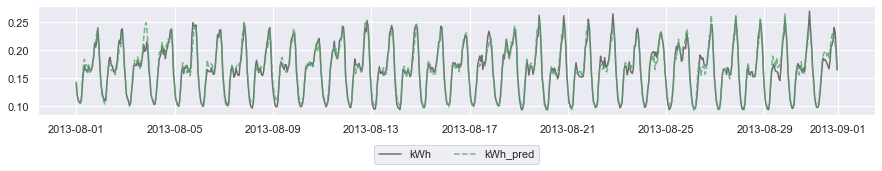

------------------------------------------------
Model: Linear regression
R SQUARED: 0.9367
MAE: 0.0133


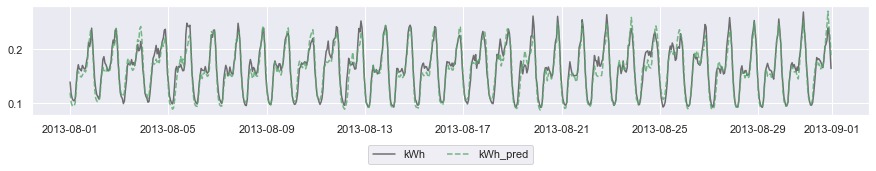

------------------------------------------------
Model: LGBM
R SQUARED: 0.9635
MAE: 0.0098


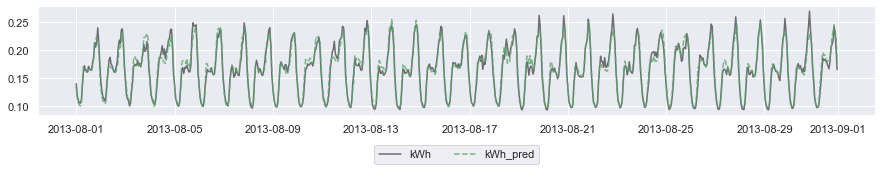

------------------------------------------------


In [ ]:
# Data split (training:2013-01~2013-06; test:2013-07~present)
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

# Create forecasting modelprint("Model: Persistent model")
testdata['kWh_pred'] = testdata['kWh_lastweek']
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

LR_model = LinearRegression()
LR_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Linear regression")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

## 4. Forecasting model of 100-houses average electricity

Next, we turn our attention to a smaller aggregation of 100 households.

In [ ]:
# Prepare dataset
df_dataset = elec_100house.copy()

df_dataset['timestamp'] = df_dataset.index
df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)
df_dataset['kWh_yesterday'] = df_dataset['kWh'].shift(24)
df_dataset['kWh_lastweek'] = df_dataset['kWh'].shift(7*24)

df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
df_dataset = df_dataset.drop('date',axis=1)

df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)

df_dataset.set_index('timestamp',inplace=True)

df_dataset = df_dataset.dropna()

Model: Persistent model
R SQUARED: 0.8414
MAE: 0.0251


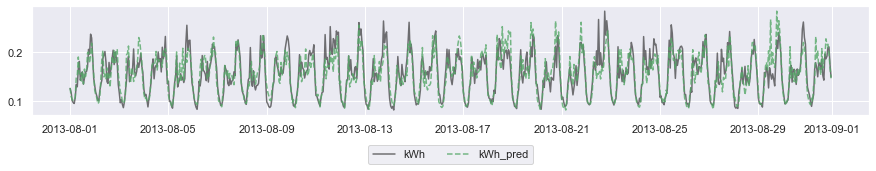

------------------------------------------------
Model: Linear regression
R SQUARED: 0.868
MAE: 0.0231


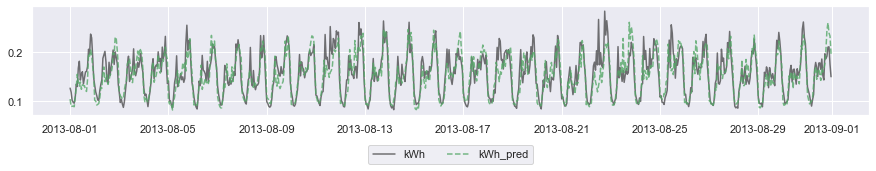

------------------------------------------------
Model: LGBM
R SQUARED: 0.8866
MAE: 0.0212


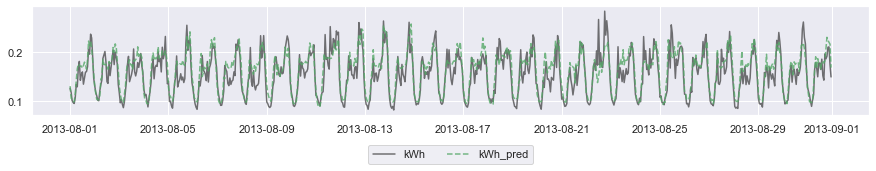

------------------------------------------------


In [ ]:
# Data split (training:2013-01~2013-06; test:2013-07~present)
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

# Create forecasting model
testdata['kWh_pred'] = testdata['kWh_lastweek']
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Persistent model")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

LR_model = LinearRegression()
LR_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Linear regression")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

Without changing anything else, we immediately see a noticable drop in forecast accuracy. Next, let's step down to an even smaller aggrgeation level.

## 5. Forecasting model of 10-houses average electricity

In [ ]:
# Prepare dataset
df_dataset = elec_10house.copy()

df_dataset['timestamp'] = df_dataset.index
df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)
df_dataset['kWh_yesterday'] = df_dataset['kWh'].shift(24)
df_dataset['kWh_lastweek'] = df_dataset['kWh'].shift(7*24)

df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
df_dataset = df_dataset.drop('date',axis=1)

df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)

df_dataset.set_index('timestamp',inplace=True)

df_dataset = df_dataset.dropna()

Model: Persistent model
R SQUARED: 0.3731
MAE: 0.0443


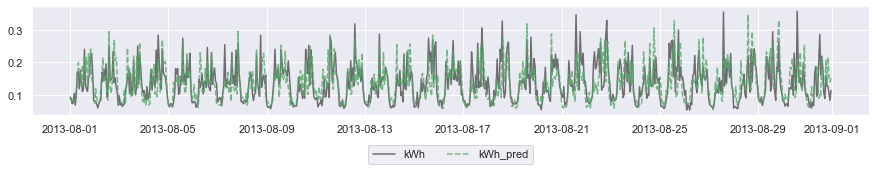

------------------------------------------------
Model: Linear regression
R SQUARED: 0.5432
MAE: 0.0403


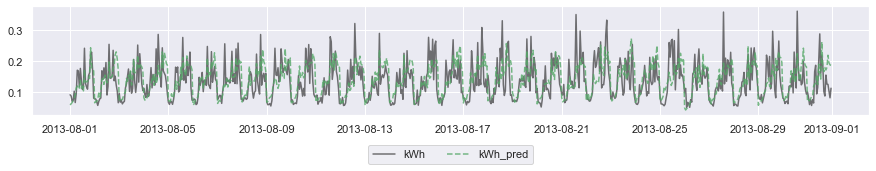

------------------------------------------------
Model: LGBM
R SQUARED: 0.6241
MAE: 0.0361


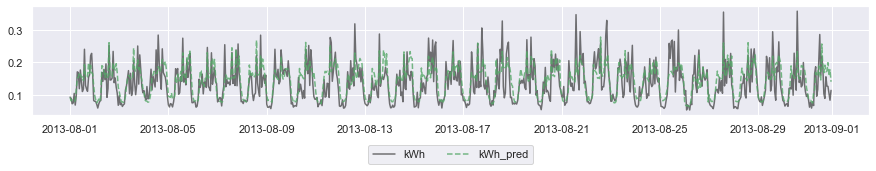

------------------------------------------------


In [ ]:
# Data split (training:2013-01~2013-06; test:2013-07~present)
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

# Create forecasting model
testdata['kWh_pred'] = testdata['kWh_lastweek']
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Persistent model")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

LR_model = LinearRegression()
LR_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Linear regression")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

At this point, even though all models are making poor predictions, the LGBM model is doing considerably better than the persistence model (recall the two were comparable at urban scale).

## 6. Forecasting model of single-house electricity

In [ ]:
# Prepare dataset
df_dataset = elec_1house.copy()

df_dataset['timestamp'] = df_dataset.index
df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)
df_dataset['kWh_yesterday'] = df_dataset['kWh'].shift(24)
df_dataset['kWh_lastweek'] = df_dataset['kWh'].shift(7*24)

df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
df_dataset = df_dataset.drop('date',axis=1)

df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)

df_dataset.set_index('timestamp',inplace=True)

df_dataset = df_dataset.dropna()

df_dataset

,kWh,year,weekday,hour,timeofweek,temperature,kWh_yesterday,kWh_lastweek,Holiday
timestamp,,,,,,,,,
2012-05-18 09:00:00,0.052,2012,4,9.0,105.0,13.69,0.079,0.153,-1.0
2012-05-18 10:00:00,0.065,2012,4,10.0,106.0,14.28,0.060,0.185,-1.0
2012-05-18 11:00:00,0.046,2012,4,11.0,107.0,15.38,0.050,0.361,-1.0
2012-05-18 12:00:00,0.929,2012,4,12.0,108.0,15.77,0.062,1.044,-1.0
2012-05-18 13:00:00,0.478,2012,4,13.0,109.0,15.28,0.084,0.149,-1.0
...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,0.447,2014,3,20.0,92.0,5.94,0.526,0.561,-1.0
2014-02-27 21:00:00,0.490,2014,3,21.0,93.0,5.03,0.438,0.583,-1.0
2014-02-27 22:00:00,0.680,2014,3,22.0,94.0,4.10,0.400,0.459,-1.0


Model: Persistent model
R SQUARED: -0.3487
MAE: 0.2128


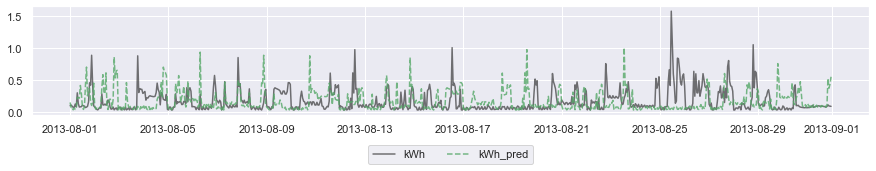

------------------------------------------------
Model: Linear regression
R SQUARED: 0.1977
MAE: 0.1881


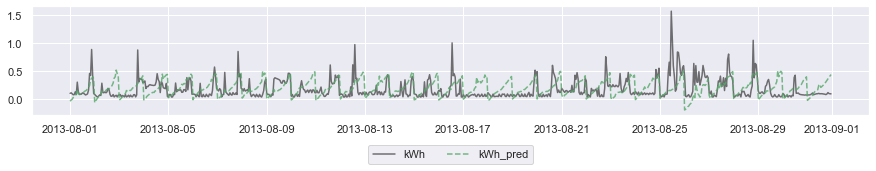

------------------------------------------------
Model: LGBM
R SQUARED: 0.1968
MAE: 0.1817


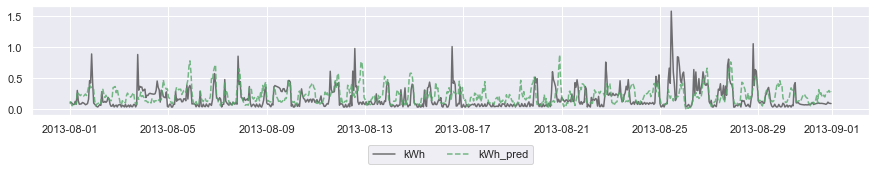

------------------------------------------------


In [ ]:
# Data split (training:2013-01~2013-06; test:2013-07~present)
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

# Create forecasting model
testdata['kWh_pred'] = testdata['kWh_lastweek']
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Persistent model")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

LR_model = LinearRegression()
LR_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Linear regression")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
plt.plot(testdata.loc['2013-8'].index, testdata.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
plt.show() 
print("------------------------------------------------")

Finally, as expected, we see quite poor predictive performance at the individual building level. This is not an artefact of the chosen building, but is a result that has been replicated over several studies in various settings.

In the next cells, we generalize these findings to plot the accuracy as a function of the scale used in the forecasting problem.

In [ ]:
list_n_sample = []
LGBM_RSQUARED = []
LGBM_MAE = []
LR_RSQUARED = []
LR_MAE = []
Naive_RSQUARED = []
Naive_MAE = []

for n_sample in tqdm.tqdm(np.arange(10,1000,10)):
    elec_houses = elec_house.sample(n=n_sample, random_state=random_state, axis=1).mean(axis=1).to_frame()
    elec_houses.columns = ['kWh']

    df_dataset = elec_houses.copy()

    df_dataset['timestamp'] = df_dataset.index
    df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
    df_dataset['year'] = df_dataset.index.year.astype('int')
    df_dataset['weekday'] = df_dataset.index.weekday
    df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
    df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

    df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)
    df_dataset['kWh_yesterday'] = df_dataset['kWh'].shift(24)
    df_dataset['kWh_lastweek'] = df_dataset['kWh'].shift(7*24)

    df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
    df_dataset = df_dataset.drop('date',axis=1)

    df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)

    df_dataset.set_index('timestamp',inplace=True)

    df_dataset = df_dataset.dropna()    
    
    traindata = df_dataset.loc['2013-01':'2013-06'].copy()
    testdata = df_dataset.loc['2013-07':].copy()

    LGB_model = lgb.LGBMRegressor()
    LGB_model.fit(traindata[list_feat], traindata['kWh'])
    testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
    RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
    MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])
    LGBM_RSQUARED.append(RSQUARED)
    LGBM_MAE.append(MAE)    
    
    LR_model = LinearRegression()
    LR_model.fit(traindata[list_feat], traindata['kWh'])
    testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
    RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
    MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])    
    LR_RSQUARED.append(RSQUARED)
    LR_MAE.append(MAE)
    
    testdata['kWh_pred'] = testdata['kWh_lastweek']
    RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
    MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])
    Naive_RSQUARED.append(RSQUARED)
    Naive_MAE.append(MAE)  
    
    list_n_sample.append(n_sample)  

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.73it/s]


<AxesSubplot:>

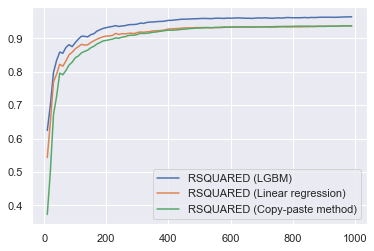

In [ ]:
df_RSQUARED = pd.DataFrame(index=list_n_sample, data={'RSQUARED (LGBM)': LGBM_RSQUARED, 
                                                      'RSQUARED (Linear regression)': LR_RSQUARED, 
                                                      'RSQUARED (Copy-paste method)': Naive_RSQUARED})
df_RSQUARED.plot()

<AxesSubplot:>

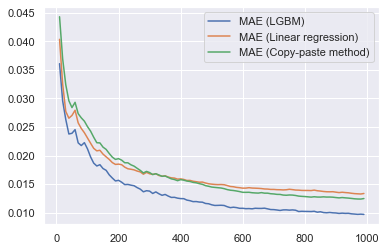

In [ ]:
df_MAE = pd.DataFrame(index=list_n_sample, data={'MAE (LGBM)': LGBM_MAE, 
                                                 'MAE (Linear regression)': LR_MAE, 
                                                 'MAE (Copy-paste method)': Naive_MAE})
df_MAE.plot()   